In [487]:
from trainer import *
from models import *

In [488]:
import torch
import torch.nn.functional as F
import torch_geometric
from torch_geometric.nn import GCNConv, GATConv
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
from tqdm.notebook import tqdm
from torch_geometric.data import DataLoader
from functorch import jacrev
import matplotlib.pyplot as plt

from torch_geometric.datasets import QM9
from ogb.nodeproppred import PygNodePropPredDataset
from torch_geometric.loader import NeighborLoader

from sklearn.preprocessing import MinMaxScaler
import numpy as np

from torch_geometric.utils import to_dense_adj
import networkx as nx

In [489]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [490]:
task_lst = ["node_classify", "node_regress", "graph_regress"]
task = task_lst[2]

In [491]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [492]:
dataset_size = len(dataset)
indices = list(range(dataset_size))
sampled_indices = np.random.choice(indices, 20000, replace=False)

In [493]:
if task == "graph_regress":
    dataset = QM9("data/QM9/")
    dataset = dataset[sampled_indices]
    train_dataset = dataset[:14000]
    val_dataset = dataset[16000:18000]
    test_dataset = dataset[18000:20000]
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    
    input_train = train_loader
    input_eval = [val_loader, test_loader]
    criterion = torch.nn.MSELoss()
    
elif task == "node_classify":
    dataset = PygNodePropPredDataset(name='ogbn-arxiv')
    data = dataset[0]
    data = data.to(device)
    split_idx = dataset.get_idx_split()
    train_idx = split_idx['train']
    val_idx = split_idx['valid']
    test_idx = split_idx['test']
    
    input_train = [data, train_idx]
    input_eval = [data, train_idx, val_idx, test_idx]
    criterion = torch.nn.CrossEntropyLoss()

/home/zhishang/anaconda3/lib/python3.8/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [496]:
model = GCN(input_dim=dataset.num_node_features, hidden_dim=64, output_dim=1, task=task).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

In [497]:
for epoch in range(100):
    loss = train(input_train, task, model, optimizer, criterion, device)
    train_metric, val_metric, test_metric = test(input_eval, task, model, criterion, device)
    
    #if epoch // 10 > 0 and epoch % 10 == 0:
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train Metric: {train_metric:.4f}, Val Metric: {val_metric:.4f}, Test Metric: {test_metric:.4f}')

Epoch: 000, Loss: 385740.3646, Train Metric: 0.0000, Val Metric: 675.6866, Test Metric: 641.6213
Epoch: 001, Loss: 22807.0907, Train Metric: 0.0000, Val Metric: 607.0001, Test Metric: 572.3354
Epoch: 002, Loss: 20337.7075, Train Metric: 0.0000, Val Metric: 557.9955, Test Metric: 519.8002
Epoch: 003, Loss: 18944.1617, Train Metric: 0.0000, Val Metric: 562.8463, Test Metric: 524.6888
Epoch: 004, Loss: 18627.5950, Train Metric: 0.0000, Val Metric: 630.5318, Test Metric: 593.7592
Epoch: 005, Loss: 18326.0917, Train Metric: 0.0000, Val Metric: 524.8468, Test Metric: 484.4522
Epoch: 006, Loss: 18343.9379, Train Metric: 0.0000, Val Metric: 533.5198, Test Metric: 493.0487
Epoch: 007, Loss: 18309.9770, Train Metric: 0.0000, Val Metric: 474.3576, Test Metric: 431.2722
Epoch: 008, Loss: 18616.5634, Train Metric: 0.0000, Val Metric: 562.6755, Test Metric: 523.9996
Epoch: 009, Loss: 18423.0498, Train Metric: 0.0000, Val Metric: 585.8152, Test Metric: 548.2445
Epoch: 010, Loss: 18553.1689, Train Met

KeyboardInterrupt: 

In [498]:
model = model.cpu()
data = data.cpu()
outputs = model(data.x, data.edge_index)

In [499]:
if task == "node_classify":
    train_loader = NeighborLoader(
    data,
    input_nodes=train_idx,
    num_neighbors=[10, 10, 10]
)
    for sub_data in tqdm(train_loader):
        if (sub_data.num_nodes > 30) and(sub_data.num_nodes <= 50) and (torch.sum(sub_data.y.flatten() == 5) > 5):
            print(sub_data)
            break

elif task == "graph_regress":
    for sub_data in dataset:
        if 'O' in sub_data.smiles:
            if sub_data.x.shape[0] >= 18:
                break

In [500]:
dataset_size = len(train_dataset)
indices = list(range(dataset_size))
sampled_indices = np.random.choice(indices, 1000, replace=False)

In [501]:
def update_f(x, edge_index):
    return model(x, edge_index)

In [502]:
# compute jacobian matrix DxD
if task == "node_classify":
    sum_jac = torch.zeros(data.x.shape[1], outputs.shape[1])
    for sub_data in tqdm(train_loader[:500]):
        sub_data = sub_data.cpu()
        jac = jacrev(update_f)(sub_data.x, sub_data.edge_index)
        jac = torch.mean(jac, dim=0)
        jac = torch.mean(jac, dim=1)
        sum_jac += jac.T
    
elif task == "graph_regress":
    sum_jac = torch.zeros(data.x.shape[1], outputs.shape[1])
    for sub_data in tqdm(train_dataset[sampled_indices]):
        sub_data = sub_data.cpu()
        jac = jacrev(update_f)(sub_data.x, sub_data.edge_index)
        jac = torch.mean(jac, dim=0)
        jac = torch.mean(jac, dim=1)
        sum_jac += jac.T
        
    sum_jac = sum_jac/len(sampled_indices)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [503]:
# compute jacobian matrix NxN
jac = jacrev(update_f)(sub_data.x, sub_data.edge_index)
jac = torch.mean(jac, dim=1)
jac = torch.mean(jac, dim=2)

In [504]:
raw_grad = sum_jac.detach().numpy()
grad = raw_grad
gram = grad @ grad.T

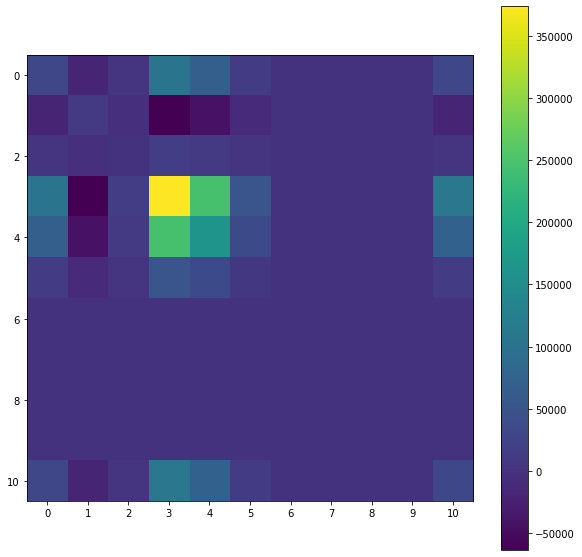

In [505]:
plt.figure(figsize=(10, 10))
plt.imshow(gram)
plt.xticks([idx for idx in range(len(gram))], [idx for idx in range(len(gram))])
plt.colorbar()

In [506]:
eig_vals, eig_vecs = np.linalg.eig(gram)

Text(0.5, 1.0, 'Eigenvalues after removing largest')

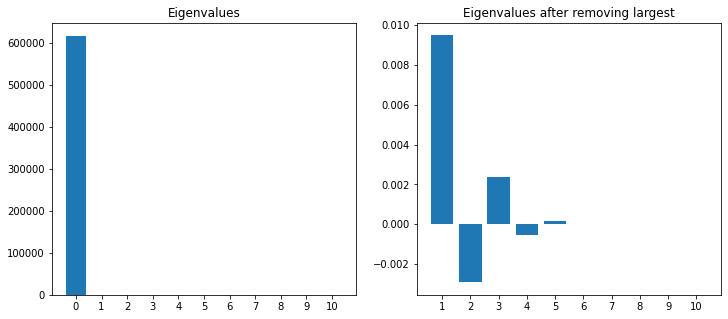

In [507]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].bar([idx for idx in range(len(eig_vals))], eig_vals)
axs[0].set_xticks([idx for idx in range(len(eig_vals))], [idx for idx in range(len(eig_vals))])
axs[0].set_title("Eigenvalues")

axs[1].bar([idx for idx in range(1, len(eig_vals))], eig_vals[1:])
axs[1].set_xticks([idx for idx in range(1, len(eig_vals))], [idx for idx in range(1, len(eig_vals))])
axs[1].set_title("Eigenvalues after removing largest")

Text(0.5, 1.0, 'Top Eigenvector')

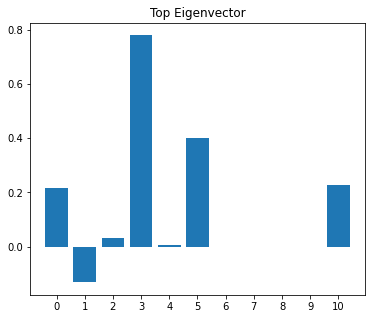

In [525]:
fig, axs = plt.subplots(1, 1, figsize=(6, 5))
axs.bar([idx for idx in range(len(eig_vecs[:, 0]))], eig_vecs[:, 0])
axs.set_xticks([idx for idx in range(len(eig_vecs[:, 0]))], [idx for idx in range(len(eig_vecs[:, 0]))])
axs.set_title("Top Eigenvector")

In [519]:
raw_grad = jac.detach().numpy()
grad = raw_grad
gram = grad.T @ grad

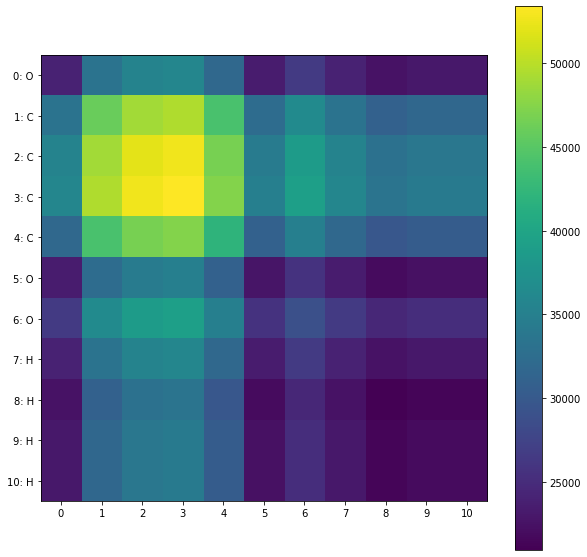

In [532]:
plt.figure(figsize=(10, 10))
plt.imshow(gram)
plt.xticks([idx for idx in range(len(gram))], [idx for idx in range(len(gram))])
plt.yticks([idx for idx in range(len(gram))], [class_names[idx] for idx in range(len(gram))])
plt.colorbar()

In [535]:
eig_vals, eig_vecs = np.linalg.eig(gram)

In [538]:
eindex_to_class = {0: 'H', 1: 'C', 2: 'N', 3: 'O', 4: 'F', 5: 'Atomic #', 6: 'Accept', 7: 'Doner', 8: 'Aromatic', 9: 'sp', 10: 'number of H'
}

Text(0.5, 1.0, 'Top Eigenvector')

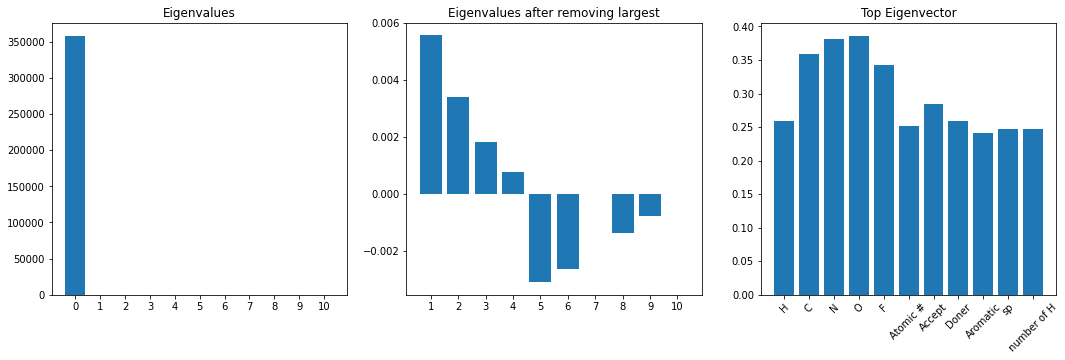

In [540]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
axs[0].bar([idx for idx in range(len(eig_vals))], eig_vals)
axs[0].set_xticks([idx for idx in range(len(eig_vals))], [idx for idx in range(len(eig_vals))])
axs[0].set_title("Eigenvalues")

axs[1].bar([idx for idx in range(1, len(eig_vals))], eig_vals[1:])
axs[1].set_xticks([idx for idx in range(1, len(eig_vals))], [idx for idx in range(1, len(eig_vals))])
axs[1].set_title("Eigenvalues after removing largest")

axs[2].bar([idx for idx in range(len(eig_vecs[:, 0]))], eig_vecs[:, 0])
axs[2].set_xticks([idx for idx in range(len(eig_vecs[:, 0]))], [eindex_to_class[idx] for idx in range(len(eig_vecs[:, 0]))], rotation=45)
axs[2].set_title("Top Eigenvector")

In [521]:
adj = to_dense_adj(sub_data.edge_index.cpu()).numpy()
adj = adj[0]
graph = nx.Graph(adj)

In [522]:
index_to_class = {
    0: 'H', 
    1: 'C', 
    2: 'N', 
    3: 'O', 
    4: 'F'
}

In [528]:
one_hot_encodings = sub_data.x[:, :5]
class_names = {}
idx = 0
for encoding in one_hot_encodings:
    index = list(encoding.numpy()).index(1)
    class_names[idx] = f"{idx}: {index_to_class[index]}"
    idx += 1

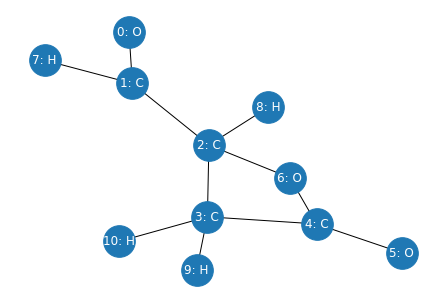

In [534]:
nx.draw(graph, labels=class_names, node_size=1000, font_color="white")